# Loads the processed h5 file and plots data

debugging: the pump probe signal looks weird after implementing mpi

In [5]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import sys

sys.path.insert(0, '../src/')
from data_analysis import *
from integrators import *
#from analysis import *
from pprint import pprint

In [6]:
# input parameters
run = '0018_droplets_10um_2mm'

# constants
detector_distance = 0.12 # m
energy = 9.5 # keV

# hit finders parameters
#iq_thr = 0.12 # photon/pix/i0
r_min, r_max = 20,30 # bins

### load data

In [7]:
def load_processed_data(run):
    '''
    loads data from processed h5
    '''

    h5path = '/sf/bernina/data/p17743/res/work/hdf5/run%s.h5'%run
    h5file = h5py.File(h5path,'r')
    img = h5file['JF7/2D_sum'][:]
    Iq = h5file['JF7/I_Q'][:]
    r = h5file['JF7/Q_bins'][:]

    try:
        i0 = h5file['JF3/i0'].value
    except KeyError:
        i0 = h5file['JF7/i0'].value

    nshots = h5file['JF7/num_shots'].value

    laser_i0 = h5file['SARES20/i0'].value
    try:
        laser_on = h5file['SARES20/laser_on'].value
    except KeyError:
        laser_on = h5file['BERNINA/laser_on'].value
        
    try:
        event_ID = h5file['pulse_id'].value
    except:
        event_ID = h5file['BERNINA/event_ID'].value

    print('run%s: %d shots' % (run, h5file['JF7/num_shots'].value))
    h5file.close()

    return img,Iq,r,int(nshots),i0,laser_i0,laser_on,event_ID #maybe use dictionary here

In [9]:
print(event_ID[:10])
print(laser_on[:10])

[7749683740 7749683744 7749683748 7749683752 7749683756 7749683760
 7749683764 7749683768 7749683772 7749683776]
[0 1 0 1 0 1 0 1 0 1]


In [23]:
print(event_ID)
print(laser_on)

[7749683740 7749683744 7749683748 7749683752 7749683756 7749683760
 7749683764 7749683768 7749683772 7749683776]
[False  True False  True False  True False  True False  True]


In [10]:
# load data
img,Iq,r,nshots,i0,laser_i0,laser_on,event_ID = load_processed_data(run)
laser_on = laser_on.astype(bool)

# convert q_scale
q = q_scale(r,detector_distance=detector_distance,photon_energy=energy*1000)

# convert intensity to photon/pix
#img/=energy
Iq /=energy
i0 /=energy

run0018_droplets_10um_2mm: 18000 shots


<IPython.core.display.Javascript object>


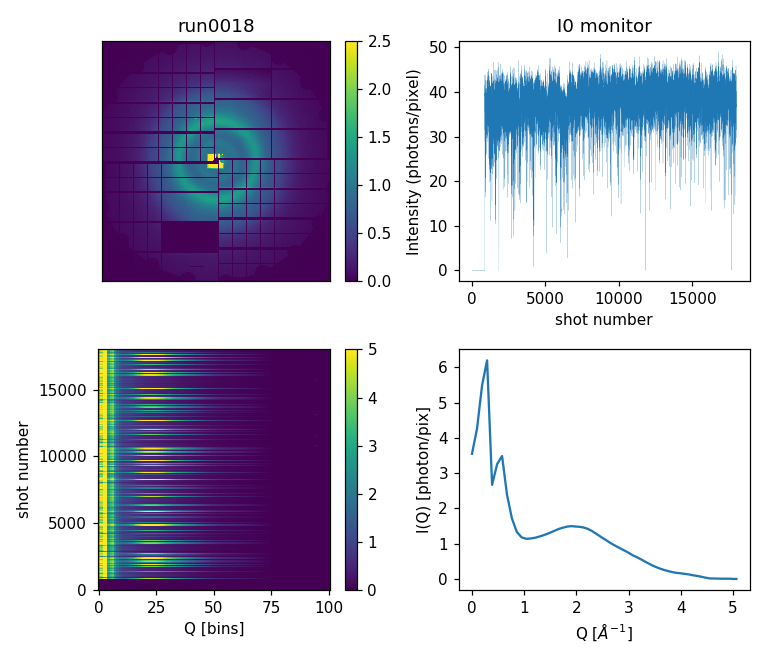

In [11]:
plt.figure(figsize=[7,6])
plt.subplot(2,2,1)
plt.title('run%s'%run[:4])
plt.imshow(img/nshots,clim=[0,2.5],origin='lower')
plt.colorbar()
plt.xticks([],'')
plt.yticks([],'')
plt.tight_layout()

plt.subplot(2,2,2)
plt.title('I0 monitor')
plt.plot(i0[:nshots],lw=.1)
plt.xlabel('shot number')
plt.ylabel('Intensity (photons/pixel)')

plt.subplot(2,2,3)
plt.imshow(Iq,aspect='auto',clim=[0,5],origin='lower')
plt.colorbar()
plt.tight_layout()
plt.ylabel('shot number')
plt.xlabel('Q [bins]')

plt.subplot(2,2,4)
plt.plot(q,np.average(Iq,axis=0))
plt.xlabel('Q [$\AA^{-1}$]')
plt.ylabel('I(Q) [photon/pix]')

plt.tight_layout()
plt.show()

### normalise to i0

In [12]:
def do_histogram(a,bi,bf,db):
    '''
    finally a good histogram function
    '''
    bins = np.arange(bi-db,bf+db,db)
    y,x_tmp = np.histogram(a,bins=bins)
    x = np.array([(bins[j]+bins[j+1])/2. for j in range(len(bins)-1)])
    return x,y

In [13]:
Iq_norm = np.zeros(Iq.shape)
i0_avg = np.average(i0)
norm = i0/i0_avg
for i in range(int(nshots)):
    Iq_norm[i]=Iq[i]/norm[i]

### find hits

In [14]:
def find_hits(Iq, threshold=0.015, r_min=30, r_max=80):
    '''
    finds the shots that hit water droplets based on
    a simple threshold on the average over a q-range
    note: give Iq in photon/pix units/i0
    '''
    metric = np.average(Iq[:,r_min:r_max],axis=1)
    hits = metric>threshold
    return metric,hits


0.192


<IPython.core.display.Javascript object>


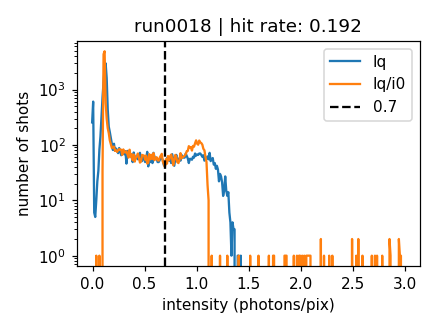

In [15]:
iq_thr = 0.7
metric_tmp,hits_tmp = find_hits(Iq,threshold=iq_thr)
hit_rate_tmp =len(hits_tmp[hits_tmp>0])/nshots

metric,hits = find_hits(Iq_norm,threshold=iq_thr)
hit_rate =len(hits[hits>0])/nshots

print(hit_rate)
plt.figure(figsize=[4,3])
x,y = do_histogram(metric_tmp,0,3,.01)
plt.plot(x,y)
x,y = do_histogram(metric,0,3,.01)
plt.plot(x,y)
plt.axvline(x=iq_thr,c='black',ls='--')
plt.legend(['Iq','Iq/i0',iq_thr])
plt.ylabel('number of shots')
plt.yscale('log',nonposy='clip')
plt.xlabel('intensity (photons/pix)')
plt.title('run%s | hit rate: %.3f'%(run[:4],hit_rate))
plt.tight_layout()

plt.show()


In [16]:
def normalize(array, low, high):
    n = np.sum(array[low:high])
    norm_array = array / n
    return norm_array

def calculate_hits(Iq,energy=9.5):
    hit = np.average(Iq[hits[i],:], axis=0) 
    miss = np.average(Iq[np.logical_not(hits[i]),:], axis=0)
    return 

In [17]:
def pump_probe_signal(Iq,hits,laser_on,q_min = 20, q_max = 30):
    '''
    calculate the pump probe signal
    '''
    # averages
    hit_avg = np.average(Iq[hits,:], axis=0) 
    miss_avg = np.average(Iq[np.logical_not(hits),:], axis=0) 

    # misses (laser on/off)
    off_misses = np.average(Iq[np.logical_not(hits) * np.logical_not(laser_on),:], axis=0)
    on_misses  = np.average(Iq[np.logical_not(hits) * laser_on,:], axis=0)

    # hits (laser on/off)
    off_hits = np.average(Iq[hits * np.logical_not(laser_on),:], axis=0)
    on_hits  = np.average(Iq[hits * laser_on,:], axis=0)

    #n_hits_on_off = [(np.logical_not(hits) * np.logical_not(laser_ons)).sum(), (np.logical_not(hits) * laser_ons).sum(), np.sum(hits[i] * np.logical_not(laser_ons[i])), np.sum(hits[i] * laser_ons[i])])

    # signal
    diff_signal = normalize(on_hits, q_min, q_max) - normalize(off_hits, q_min, q_max) # / normalize(off_hit, l, h)

    # error estimator (not real error)
    # calculates the diff_signal for the miss as a reference
    off_hits_1 = np.average(Iq[hits * np.logical_not(laser_on)][:-1:2], axis=0)
    off_hits_2 = np.average(Iq[hits * np.logical_not(laser_on)][1::2], axis=0)
    diff_error = normalize(off_hits_1, q_min, q_max) - normalize(off_hits_2, q_min, q_max)

    return hit_avg,miss_avg,diff_signal,diff_error

hit_avg,miss_avg,diff_signal,diff_error =  pump_probe_signal(Iq,hits,laser_on,q_min = 20, q_max = 30)

<IPython.core.display.Javascript object>


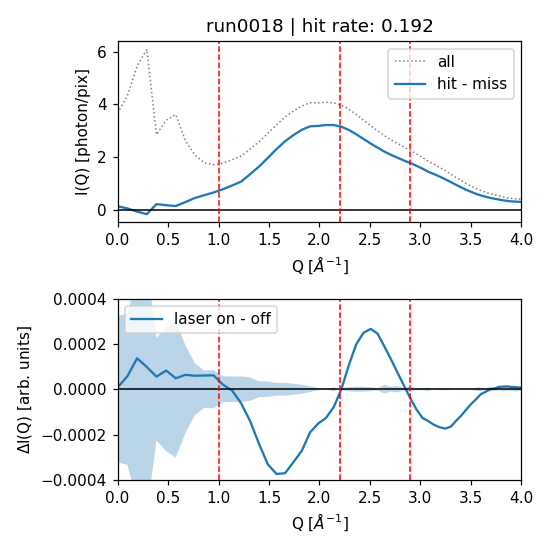

In [20]:
plt.figure(figsize=[5,5])
plt.subplot(2,1,1)
plt.title('run%s | hit rate: %.3f'%(run[:4],hit_rate))

plt.plot(q, hit_avg,':',c='gray' ,lw=1,label='all')
plt.plot(q, hit_avg - miss_avg, label='hit - miss')

plt.xlabel('Q [$\AA^{-1}$]')
plt.ylabel('I(Q) [photon/pix]')
plt.legend(loc='upper right')
plt.axhline(0,c='black',lw=1)
plt.axvline(1.,c='red',lw=1,ls='--')
plt.axvline(2.2,c='red',lw=1,ls='--')
plt.axvline(2.9,c='red',lw=1,ls='--')
plt.xlim(0,4)

ax = plt.subplot(2,1,2)
ax.plot(q, diff_signal, label='laser on - off')
ax.fill_between(q, -diff_error, diff_error, alpha=0.3)
plt.ylabel('$\Delta$I(Q) [arb. units]')
plt.ylim([-4e-4,4e-4])#plt.figure()
plt.xlabel('Q [$\AA^{-1}$]')
plt.legend()
plt.xlim(0,4)

plt.axhline(0,c='black',lw=1)
plt.axvline(1.,c='red',lw=1,ls='--')
plt.axvline(2.2,c='red',lw=1,ls='--')
plt.axvline(2.9,c='red',lw=1,ls='--')

plt.tight_layout()
#plt.savefig('fluence_droplets_10um_4mm_radial_profile_on_off_%d_shots.png' % n_shots)
plt.show()